# Data programming in Python DSM020 - Coursework 2

## Adam Zebrowski - 190113494

# Customer Segmentation:  How can high value customers be identified?

## Introduction/Context

This project will analyse the Online Retail Data Set from the UCI Machine Learning Repository that can be found here: https://archive.ics.uci.edu/ml/datasets/Online+Retail. 
The data contains records of transactions between 01/12/2010 and 09/12/2011 for a UK based online site in an Excel format.

The aim of the project is to analyse the purchases and transactions made by the  approximately 4000 customers in the datasaet to develop a model for identifying customer segment groups and categories. 
Doing this will help the business to better understand the needs of each customer category and also identify its most valuable customers in order to grow this segment.

Initial analysis of the dataset will help to provide an overview that will be helpful in devising appropriate algorithms for building an effective classification model for the task.

This exercise will focus on acquiring and preparing the dataset for further analysis.
The dataset is available for free download on the UCI website and has been anonymised for widespread machine learning research and modelling.

First step is to explore the data to understand its structure.
This includes processing and preparation of the data for summary statistics and visualisations.







### Import Libraries that will be used for data exploration and processing

pandas for manipulating and processing of labeled and columnar data
numpy for efficient and fast scientific operations on large amount of data 
matplotlib for graphing of data
seaborn for data visualisation

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
import datetime as dt


#For Use in Part 2 of the Project Below
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans 
#import datetime
from datetime import datetime
from datetime import timedelta
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler
import plotly.express as px



## Data Preparation

Data is in an excel format which provides a tabular strtucture that we can use for dataframe manipulation, numerical and statistical analysis.

Information on whether there are null values in the dataset was not available on the UCI website (N/A). Therefore we have to check for this.

In [2]:
#Load the data file

dfRetailData = pd.read_excel("Online Retail.xlsx", sheet_name = "Online Retail")


### Clean up dataset

In [3]:
#View the first lines of dataset to check the contents

dfRetailData.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
#Obtain information about the different columns in the dataset including 

dfRetailData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


There are 8 columns in the dataset and 541909 instances as indicated in UCI dataset description.

There appears to be some null values for Description and Customer ID.  


In [5]:
#Check column distribution of null values and their proportions
 
Column_Info= pd.DataFrame(dfRetailData.dtypes).T.rename(index={0:'column type'})
Column_Info= Column_Info.append(pd.DataFrame(dfRetailData.isnull().sum()).T.rename(index={0:'null values (nb)'}))
Column_Info= Column_Info.append(pd.DataFrame(dfRetailData.isnull().sum()/dfRetailData.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(Column_Info)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


Almost 25% of the dataset does not have a customer ID.  Looking at the structure of the datasey it will be difficult to replace these null values based on the available information given.  These will be removed
  

In [6]:

#Remove Null Values
dfRetailData.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

#Check null values in dataset and technical info on the columns
dfRetailData.isnull().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

It appears removing the null 'CustomerID' values also removed the null 'Description' values.

In [7]:
#Check dataset dimensions
print('Dataframe dimensions:', dfRetailData.shape)


Dataframe dimensions: (406829, 8)


In [8]:
#Find duplicates in dataset and delete them

print('Number of Duplicate Entries: {}'.format(dfRetailData.duplicated().sum()))
dfRetailData.drop_duplicates(inplace = True)

Number of Duplicate Entries: 5225


In [9]:
#Convert nominal types described in UCI source websites into categories

dfRetailData['CustomerID'] = dfRetailData['CustomerID'].astype('int').astype('category')

# Turning object columns into categories also reduces used memory
categories = ['InvoiceNo', 'StockCode', 'Description', 'Country']
for c in categories:
    dfRetailData[c] = dfRetailData[c].astype('category')
print(dfRetailData.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    401604 non-null  category      
 1   StockCode    401604 non-null  category      
 2   Description  401604 non-null  category      
 3   Quantity     401604 non-null  int64         
 4   InvoiceDate  401604 non-null  datetime64[ns]
 5   UnitPrice    401604 non-null  float64       
 6   CustomerID   401604 non-null  category      
 7   Country      401604 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(1), int64(1)
memory usage: 16.8 MB
None


Note that memory usage has gone from 33.1+ MB to 16.8MB

### Explore Data


#### 1.0  Dataset Overview



In [10]:
# number of unique values
n_unique = dfRetailData.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
InvoiceNo      22190
StockCode       3684
Description     3896
Quantity         436
InvoiceDate    20460
UnitPrice        620
CustomerID      4372
Country           37
dtype: int64


There are a total of 4372 customers from 37 different countries  and 3684 different products available

##### 1.2 Overview of purchases from different countries

Text(0, 0.5, 'Countries')

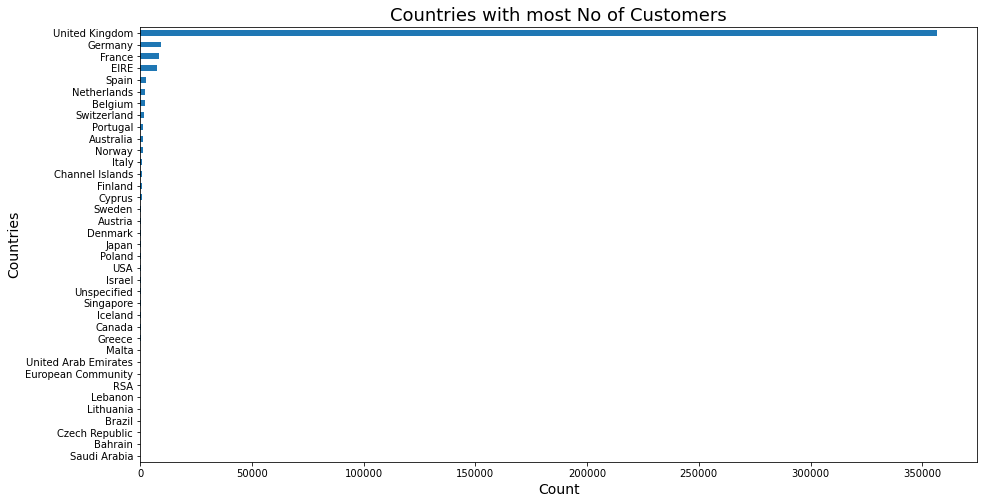

In [11]:
#Plot the distribution of customers by country 
plt.figure(figsize=(15,8))
#Use horizontal bar chart of type 'barh'
dfRetailData.groupby('Country')['CustomerID'].agg('count').sort_values().plot(kind='barh')
plt.title("Countries with most No of Customers",fontsize=18)
plt.xlabel("Count",fontsize=14)
plt.ylabel("Countries",fontsize=14)

It is observed that the large proportion of customers come from the United Kingdom.  Germany follows distantly then France and EIRE.  Spain, Netherlands and Belguim then come after these leading countries

In [12]:
#Copy data for more analysis
data = dfRetailData.copy()
data['Total'] = data['Quantity'] * data['UnitPrice']
data['Invoice_Year'] = data['InvoiceDate'].dt.year
data['Invoice_Month'] = data['InvoiceDate'].dt.month
data['Invoice_Day'] = data['InvoiceDate'].dt.day

Text(0, 0.5, 'Countries')

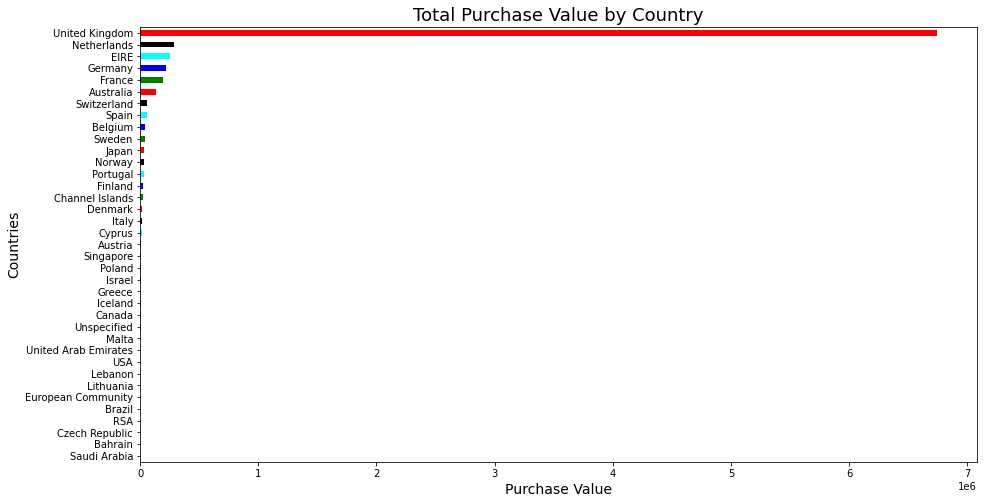

In [13]:
# Check purchase value (Total Sales) by country
plt.figure(figsize=(15,8))
data.groupby('Country')['Total'].sum().sort_values().plot(kind='barh', color=['black', 'red', 'green', 'blue', 'cyan'])
plt.title("Total Purchase Value by Country",fontsize=18)
plt.xlabel("Purchase Value",fontsize=14)
plt.ylabel("Countries",fontsize=14)


It is observed that the UK remains the most valuable in terms of value of purchases.  
However, Netherlands comes 2nd in purchase value despite having the 6th most number of customers and Australia comes 6th in terms of purchase value while 10th in terms of number of customers.  I

It is noted that Germany and France show lesser value of purchases compared to number of customers from the country.

**This is something to note for future analysis during the modeling and classification phase for identifying location of high value customers.

##### 1.3  Overview of Total Sales with Time

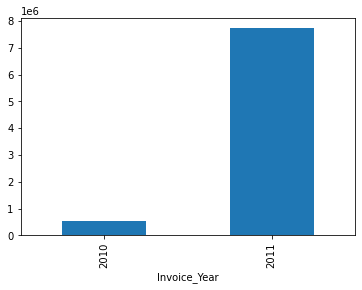

In [14]:
#Sales performance each year
per_year_total = data.groupby('Invoice_Year')['Total'].sum()
per_year_total.plot(kind='bar')
plt.show()


Of the two years in the dataset, most of the sales occured in 2011.  Let's dig deeper into this by checking how sales were distributed monthly

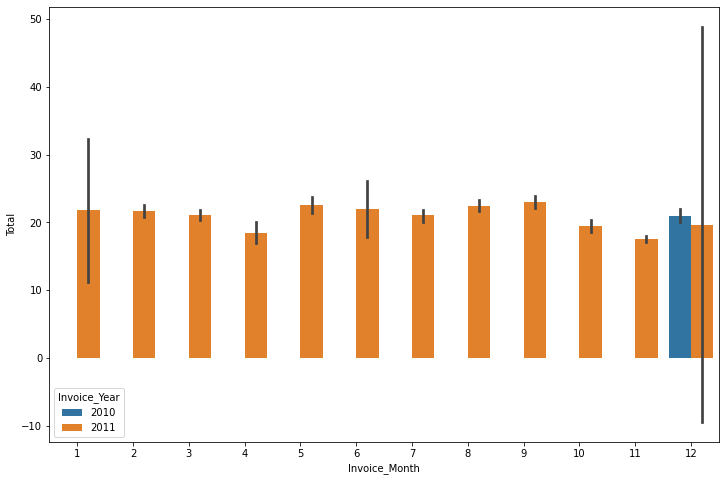

In [15]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Invoice_Month', y='Total', data=data, hue='Invoice_Year')
plt.show()

The barplot shows that sales was only recorded for the 12th month in 2010.  The data for the 12th month is significantly spread out with outliers as shown with the error bar.  

*This should be investigated for futher cleaning of data as well as month 1 and 6 for 2011.

#### 2.0 Customer and Purchasing Overview

##### 2.1 Products with the Most Purchase

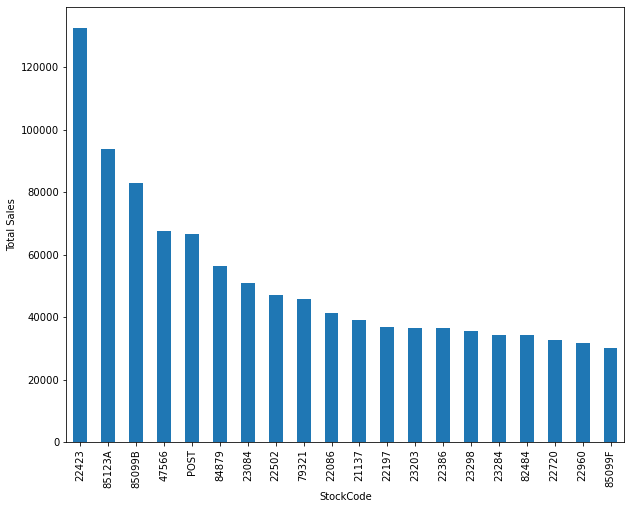

In [16]:
#plot to see the products with the most purchase in the datset
plt.figure(figsize=(10, 8))
top_stock_total = data.groupby('StockCode')['Total'].sum().sort_values(ascending=False)[:20]
top_stock_total.plot(kind='bar')
plt.ylabel('Total Sales')
plt.show()

Product with stock code 2243 produced the most sales in the time period within the dataset

##### 2.2 Group Customers by Quantity Bought


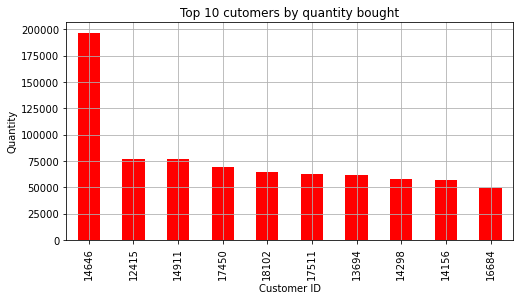

In [17]:
#Find top customers

top_customers = data.groupby('CustomerID')['Quantity'].sum()
top_customers = top_customers.sort_values(ascending=False).head(10)


plt.figure(figsize=(8,4))
top_customers.plot(kind='bar', color='red')
plt.title('Top 10 cutomers by quantity bought')
plt.xlabel('Customer ID')
plt.ylabel('Quantity')
plt.grid()
plt.show()

##### 2.2 Group Customers by Value of Products Bought

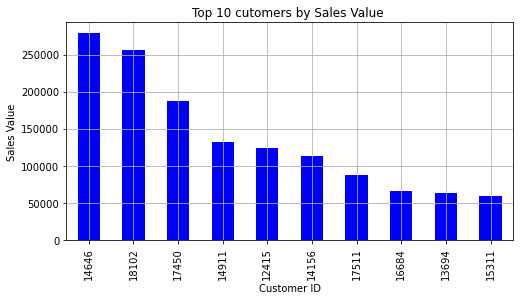

In [18]:
top_customers = data.groupby('CustomerID')['Total'].sum()
top_customers = top_customers.sort_values(ascending=False).head(10)


plt.figure(figsize=(8,4))
top_customers.plot(kind='bar', color='blue')
plt.title('Top 10 cutomers by Sales Value ')
plt.xlabel('Customer ID')
plt.ylabel('Sales Value')
plt.grid()
plt.show()

It is observed that from the two plots above that some customers buy less quantity but spend more

## Summary

A number of data cleaning operatins were performed on the dataset to remove null values and ensure that the definitions of the columns as categories were preserved.  These actions also improved the efficiency of the data analysis.  
It was observed from data exploration that further analysis for modeling and classificatiion in order to identify high value customers should not only consider quantity of items bought but also their values. 
In addition to specifically identifying high value customers based on Customer ID, it would also be useful to relate high value customers in terms of quantity bought and sales value per customers to the specific countries.
This will help in developing and growing the customer base for international retail sales outside the UK.

## References

Anaconda, 2021b. NumPy Documentation. [Online] 
Available at: https://numpy.org/doc/stable/user/whatisnumpy.html
[Accessed 13th June 2021].

Anaconda, 2021c. mapplotlib Documentation. [Online] 
Available at: https://matplotlib.org/stable/tutorials/introductory/usage.html#sphx-glr-tutorials-introductory-usage-py
[Accessed 13th June 2021].

Anaconda, 2021d. Categorical data. [Online] 
Available at: https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html
[Accessed 15th June 2021].

Anaconda, 2021. pandas Documentation. [Online] 
Available at: https://pandas.pydata.org/docs/getting_started/index.html
[Accessed 13th June 2021].

Chen, D., Sain, S. L. & Guo, K., 2012 . Data mining for the online retail industry: A case study of RFM model-based customer segmentation using data mining. Journal of Database Marketing and Customer Strategy Managemen, 19(3), pp. 197-208.
Harris, A., 2021. The difficulties with pandas categories. [Online] 
Available at: https://towardsdatascience.com/staying-sane-while-adopting-pandas-categorical-datatypes-78dbd19dcd8a
[Accessed 15th June 2021].

Pathak, M., 2020. Handling Categorical Data in Python. [Online] 
Available at: https://www.datacamp.com/community/tutorials/categorical-data#categorical
[Accessed 14th June 2021].

UCI Machine Learning Repository, 2021. Online Retail Data Set. [Online] 
Available at: https://archive.ics.uci.edu/ml/datasets/Online+Retail#
[Accessed 13th June 2021].


# Part 2:  Analysis

This section builds on the exploratory analysis above.  Here, an in-depth analysis of the 'Online Retail' dataset is undertaken through further data processing, statistical and visualisaiton techniques to evaluate and summarise the data towards achieving the aims and objectives of the project. 


### Project Aims and Objectives

Aims: 

Gain greater understanding of the nature of the customers and their behaviuour through analysis of transactions recorded in the dataset.

Identify if customers can be segmented meaningfully into groups within the dataset.  
This will help to gain greater understanding of their needs and allow tailoring of products and services to better satisfy customer needs. 

Recognise the most valuable customers and their characteristics in order to design strategies to grow this segment for increased sales and profits

Objectives:

What are the purchasing behaviours of the customers:

Identify customer average monetary expenditure on purchases
Understand the frequency of customer transactions 
Analyse and identify segment groups within the dataset based on purchasing behaviour.  This will help evaluate the value of different customer segments to the retailer.




### Add new Libraries 

New libraries added to the Import libraries section at the top of part 1:

StandardScaler for standardising features for machine learning
KMeans for clustering 
timedelta for calculating time duration


## Pre-processing for further analysis
Data pre-processing is required to remove any returned purchases (negative quantities) or items given away for free (zero price) in order to analyse customer value.

In [19]:
#Remove rows with no quantities (Cancelled orders with negative or zero quantities)
NoQuantities = data[data['Quantity'] <= 0].index
data.drop(NoQuantities, inplace=True )
data.shape

(392732, 12)

In [20]:
#Remove rows with no unit price. These could have been free items
NoQuantities = data[data['UnitPrice'] <= 0].index
data.drop(NoQuantities, inplace=True )
data.shape

(392692, 12)

In [21]:
#Remove rows with no income (Zero or negative monetary purchases). These could have been broken, thrown away, etc.


Noincome = data[data['Total'] <= 0].index
dfRetailData.drop(Noincome, inplace=True )
dfRetailData.shape


(401604, 8)

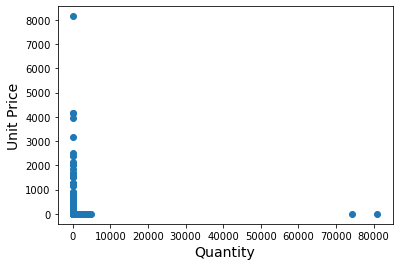

In [22]:
# Use scatterplot to check for outliers for both unit price and quantities purchased
plt.scatter(data['Quantity'], data['UnitPrice'])
plt.xlabel("Quantity",fontsize=14)
plt.ylabel("Unit Price",fontsize=14)
plt.show()

In [23]:
#There appear to be outlier/s above 5000 for unit price 
#Let's take a closer look

data[data['UnitPrice'] > 5000]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day
173382,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029,United Kingdom,8142.75,2011,5,3


In [24]:
#Checking outliers above 20,000 for Quantity
data[data['Quantity'] > 20000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,77183.6,2011,1,18
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446,United Kingdom,168469.6,2011,12,9


In [25]:
# These outliers total 3 rows in the whole dataset and can be removed to reduce skewness during analysis

# Treat the extreme values as outliers and remove them
Extremeoutliers = data[(data['UnitPrice'] > 5000) | (data['Quantity'] > 20000)].index
data.drop(Extremeoutliers, inplace = True)

#Review the dataset 
data.shape

(392689, 12)

## Evaluation of Customer Purchasing Behaviour
Evalution of customer behaviour will be based on the RFM model which enables identification of valuable customer based on their purchasing patterns in terms of :

How recently they have purchased (Recency R)]
Frequency of purchases (F)
Monetary value of purchases (M)


#### Create RFM Table

In [26]:
#format date
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], dayfirst=True)



In [27]:
#Select Rows from 2011 since this contains most sales and covers 12 months of sales
df_2011 = data[data['Invoice_Year'] == 2011]
df_2011.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total,Invoice_Year,Invoice_Month,Invoice_Day
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313,United Kingdom,19.5,2011,1,4
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,10.5,2011,1,4
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313,United Kingdom,10.5,2011,1,4
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313,United Kingdom,10.5,2011,1,4
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313,United Kingdom,12.5,2011,1,4


In [28]:
# Calculate recency using the day after last invoice date in dataset as the reference marker snapshot 

#Create snapshot date variable

SnapshotDate = df_2011['InvoiceDate'].max() + timedelta(days=1)
print(SnapshotDate)



2011-12-10 12:50:00


In [29]:
#Calculate RFM values grouped per customer

CustomerData = df_2011.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (SnapshotDate - max(x)).days,
    'InvoiceNo': 'count',
    'Total': 'sum'})
    
    


In [30]:
#Rename the columns to reflect RFM labels


CustomerData.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'Total': 'MonetaryValue'}, inplace=True)

In [31]:
# Remove any NaN values
CustomerData.dropna(axis=0, inplace=True)

In [32]:
#View details of the customer RFM table

print(CustomerData.head())
print('{:,} rows; {:,} columns'.format(CustomerData.shape[0],CustomerData.shape[1])
    ) 

            Recency  Frequency  MonetaryValue
CustomerID                                   
12347           2.0        151        3598.21
12348          75.0         14         904.44
12349          19.0         73        1757.55
12350         310.0         17         334.40
12352          36.0         85        2506.04
4,218 rows; 3 columns


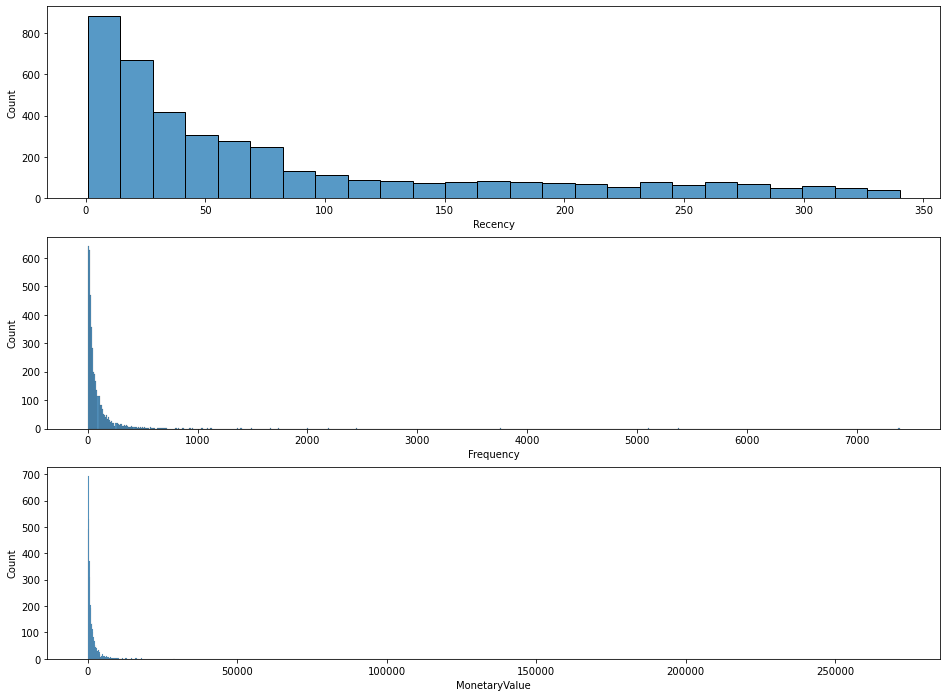

In [33]:
#To understand how customer value using RFM, clustering unsupervised machine learning algorithm k-means will be applied
# Check to make sure data is not skewed before applying features to machine learing

#Plot RFM histogram distributions

plt.figure(figsize=(16,12))
 
    #Plot Histogram distribution for R
plt.subplot(3,1,1);sns.histplot(data=CustomerData,x=CustomerData['Recency'])

#Plot Histogram distribution for F
plt.subplot(3,1,2);sns.histplot(data=CustomerData,x=CustomerData['Frequency'])

#Plot Histogram distribution for M
plt.subplot(3,1,3);sns.histplot(data=CustomerData, x=CustomerData['MonetaryValue'])


plt.show();

Examining the histograms of the RFM variables, it is shown that the scales for the three differenct features vary considerably.  
This would have to be standardised before applying machine learning algorithm like k-means clustering.  
This is because k-means is very sensitive to scales that are not comparable.  
StandardScaler from Scikit-Learn will be used to further reduce the range of the dataset to a predetermined scale.
This is applicable here since outliers have been minimised in earlier pre-processing

Also distributions of features that are approximately normal improve machine learning performance.
Quantile Transformaion from Scikit-Learn will be used to standardise the data bringing the standard deviation towards 1 (unit variance).  This tends the shape of the data towards normal distribution.

In [34]:
#Copy Customer RFM data to use for transormation
StCustomerData = CustomerData.copy()

#View Statistical summary for RFM
StCustomerData.describe()    #This inludes the mean and stadard deviation

,Recency,Frequency,MonetaryValue
count,4218.000000,4218.000000,4218.000000
mean,84.816264,87.012565,1911.567144
std,90.030454,216.393580,8183.781816
min,1.000000,1.000000,2.900000
25%,17.000000,17.000000,302.572500
50%,47.000000,40.000000,657.265000
75%,128.000000,95.000000,1609.745000
max,340.000000,7390.000000,271614.140000


#### Reduce skewness of RFM variables for k-means machine Learnign analysis

Quantile Transformation is applied.  This method allows the features to follow a uniform or normal distribution after transformation (Gaussian with 0 mean and unit variance). This reduces misleading results due to outliers and improves performance for statistical analysis and machine learning algorithms .


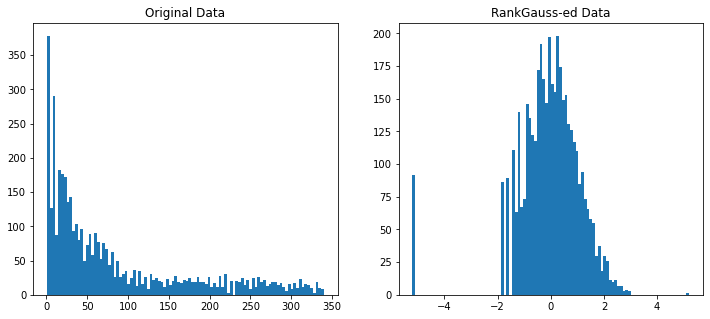

Skew Original:  1.22
Skew RankGauss-ed Data:  -1.4


In [35]:
#Apply Quantile Transformation to normalise Recency data

VTransform = QuantileTransformer(n_quantiles=100, random_state=1111, output_distribution='normal')
VTransform.fit(CustomerData[['Recency']])
StCustomerData['Recency_RankGauss'] = VTransform.transform(CustomerData[['Recency']])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
ax1.hist(CustomerData['Recency'],bins=100)
ax1.title.set_text('Original Data')
ax2.hist(StCustomerData['Recency_RankGauss'],bins=100)
ax2.title.set_text('RankGauss-ed Data')
plt.show()

#Display skewness after transformation
print("Skew Original: ", CustomerData['Recency'].skew().round(2))
print("Skew RankGauss-ed Data: ", StCustomerData['Recency_RankGauss'].skew().round(2))

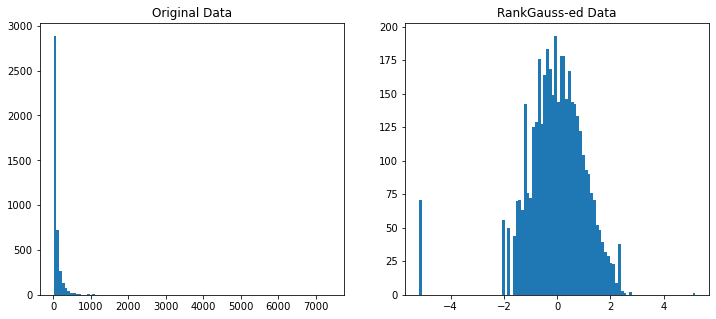

18.26
-1.25
Skew Original:  18.26
Skew RankGauss-ed Data:  -1.25


In [36]:
#Apply Quantile Transformation to normalise Frequency data

VTransform = QuantileTransformer(n_quantiles=100, random_state=1111, output_distribution='normal')
VTransform.fit(CustomerData[['Frequency']])
StCustomerData['Frequency_RankGauss'] = VTransform.transform(CustomerData[['Frequency']])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
ax1.hist(CustomerData['Frequency'],bins=100)
ax1.title.set_text('Original Data')
ax2.hist(StCustomerData['Frequency_RankGauss'],bins=100)
ax2.title.set_text('RankGauss-ed Data')
plt.show()
print(CustomerData['Frequency'].skew().round(2))
print(StCustomerData['Frequency_RankGauss'].skew().round(2))

#Display skewness after transformation
print("Skew Original: ", CustomerData['Frequency'].skew().round(2))
print("Skew RankGauss-ed Data: ", StCustomerData['Frequency_RankGauss'].skew().round(2))



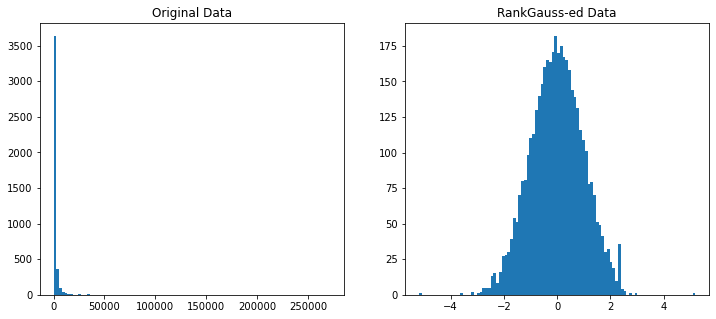

Skew Original:  20.54
Skew RankGauss-ed Data:  -0.04


In [37]:
#Apply Quantile Transformation to normalise MonetaryValue

VTransform = QuantileTransformer(n_quantiles=100, random_state=1111, output_distribution='normal')
VTransform.fit(CustomerData[['MonetaryValue']])
StCustomerData['MonetaryValue_RankGauss'] = VTransform.transform(CustomerData[['MonetaryValue']])

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,5])
ax1.hist(CustomerData['MonetaryValue'],bins=100)
ax1.title.set_text('Original Data')
ax2.hist(StCustomerData['MonetaryValue_RankGauss'],bins=100)
ax2.title.set_text('RankGauss-ed Data')
plt.show()

#Display skewness after transformation
print("Skew Original: ", CustomerData['MonetaryValue'].skew().round(2))
print("Skew RankGauss-ed Data: ", StCustomerData['MonetaryValue_RankGauss'].skew().round(2))
                                                               
    

In [38]:
#Remove Columns with Original Data

StCustomerData.drop(['Recency','Frequency','MonetaryValue'],axis=1,inplace=True)

In [39]:
#Check dataset

StCustomerData.head()

,Recency_RankGauss,Frequency_RankGauss,MonetaryValue_RankGauss
CustomerID,,,
12347,-1.807354,1.070909,1.322201
12348,0.348756,-0.816627,0.244441
12349,-0.604585,0.468075,0.750345
12350,1.977547,-0.666564,-0.547581
12352,-0.165327,0.584443,1.025422


In [40]:
#Rename Columns to RFM

StCustomerData.rename(columns={"Recency_RankGauss":"Recency","Frequency_RankGauss":"Frequency","MonetaryValue_RankGauss":"MonetaryValue"},inplace=True)
#Check Results
StCustomerData.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347,-1.807354,1.070909,1.322201
12348,0.348756,-0.816627,0.244441
12349,-0.604585,0.468075,0.750345
12350,1.977547,-0.666564,-0.547581
12352,-0.165327,0.584443,1.025422


#### Reduce Scale range of dataset features for k-means machine learning

In [41]:
#Scale to normalise data

data_scaler = StandardScaler()

# Fit and Transform The Data
NormCustomerData = data_scaler.fit_transform(StCustomerData) #This returns a numbpy array

# Check that the features a normalised with mean 0 and variance 1
print(NormCustomerData.mean(axis = 0).round(2)) 
print(NormCustomerData.std(axis = 0).round(2)) 

[-0.  0.  0.]
[1. 1. 1.]


In [42]:
#Veiw Data

#Convert numpy array outputed from StandardScaler() fit-tranfsorm 

NormCustomerData = pd.DataFrame(NormCustomerData)

#Check Statistical Summary.  See if mean converged to 0 and variance 1 compared to earlier un-normalised features
NormCustomerData.head()

,0,1,2
0,-1.447790,0.968457,1.332025
1,0.338438,-0.662946,0.248485
2,-0.451357,0.447427,0.757102
3,1.687810,-0.533246,-0.547785
4,-0.087453,0.548003,1.033654


In [43]:
#Rename Columns to RFM

NormCustomerData.rename(columns={0:"Recency",1:"Frequency",2:"MonetaryValue"},inplace=True)
#Check Results
NormCustomerData.head()

,Recency,Frequency,MonetaryValue
0,-1.447790,0.968457,1.332025
1,0.338438,-0.662946,0.248485
2,-0.451357,0.447427,0.757102
3,1.687810,-0.533246,-0.547785
4,-0.087453,0.548003,1.033654


### Clustering/Segmentation Model and Algorithm:  K-Means

Comparing clustering models for identying customer segment groups, K-Means appears to be the most suitable  as it is scalable for the  large dataset being analysed and produces not too many clusters: https://scikit-learn.org/stable/modules/clustering.html.  
This very applicable for customer segmentation for which a large number of clusters/segments can be confusing and impracticable from a business point of view.  
The model applies a powerful unsupervised machine learning algorithm for intrinsically finding groups in unlabelled data.


#### K-Means Model Implementation

The algorithm requires using an optimal number of pre-defined K value for best performance in find clusters.
This is because the performance of the algorithm will depend on the chosen K value.
It is best to choose this optimal K value by testing the K-Means algorithm for different values of K and comparing the results.

A very popular and common technique for determining optimal K value is the elbow method.  This will be used in the analysis.


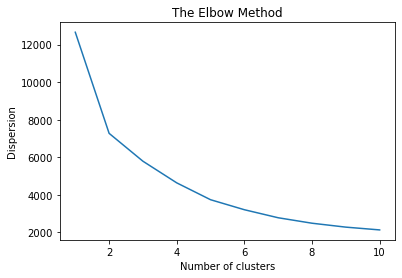

In [44]:
# Determin optimal K using Elbow Method
# The Elbow Method works by plotting cost functions of different K values. 
#The elbow is the inflection point at which dispersion between the clusters decline of dispersion 
#begins to deminish the most after and inflection point


cs = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(NormCustomerData)
    cs.append(kmeans.inertia_) #inertia measures how well Kmeans is able to cluster dataset
plt.plot(range(1, 11), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Dispersion')
plt.show()

##### Testing K-Means Performance with Potential Optimal Clusters

There is a kink at 2 which can be a good number of K to start. 
It is also observed that changes in dispersion begins to level off after 4.

We first try clustering with K of 4 to observe the clustering of the model with this.  
Clustering of the model with K of 3 and 5, one below and one above will also provide and overview of Model clusters for the different K

###### K-Means with 4 Clusters

In [45]:
kmeans = KMeans(n_clusters=4, random_state=0)

kmeans.fit(NormCustomerData)
y_kmeans = kmeans.predict(NormCustomerData)

labels = kmeans.labels_
CustomerData["Cluster"] = labels
print('Number of data points in each cluster= \n',CustomerData['Cluster'].value_counts())



# View Section of Clustering Assignments to Customers
labels = kmeans.labels_
CustomerData["Cluster"] = labels
CustomerData.head()



Number of data points in each cluster= 
 3    1863
0    1197
1    1066
2      92
Name: Cluster, dtype: int64


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,2.0,151,3598.21,0
12348,75.0,14,904.44,3
12349,19.0,73,1757.55,0
12350,310.0,17,334.40,1
12352,36.0,85,2506.04,0


In [47]:
#Plot for Visualisation of Clusters with K =4

px.scatter_3d(NormCustomerData, x='Recency', y='Frequency', z='MonetaryValue', color=labels,)

##### K-Means with 3 Clusters

In [48]:
kmeans = KMeans(n_clusters=3, random_state=0)

kmeans.fit(NormCustomerData)
y_kmeans = kmeans.predict(NormCustomerData)

labels = kmeans.labels_
CustomerData["Cluster"] = labels
print('Number of data points in each cluster= \n',CustomerData['Cluster'].value_counts())



# View Section of Clustering Assignments to Customers
labels = kmeans.labels_
CustomerData["Cluster"] = labels
CustomerData.head()



Number of data points in each cluster= 
 2    1967
1    1219
0    1032
Name: Cluster, dtype: int64


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,2.0,151,3598.21,0
12348,75.0,14,904.44,2
12349,19.0,73,1757.55,0
12350,310.0,17,334.40,1
12352,36.0,85,2506.04,0


In [49]:
#Plot for Visualisation of Clusters with K =3
import plotly.express as px
px.scatter_3d(NormCustomerData, x='Recency', y='Frequency', z='MonetaryValue', color=labels,)

##### K-Means with 5 Clusters

In [50]:
kmeans = KMeans(n_clusters=5, random_state=0)

kmeans.fit(NormCustomerData)
y_kmeans = kmeans.predict(NormCustomerData)

labels = kmeans.labels_
CustomerData["Cluster"] = labels

print('Number of data points in each cluster= \n',CustomerData['Cluster'].value_counts())



# View Section of Clustering Assignments to Customers
labels = kmeans.labels_
CustomerData["Cluster"] = labels
CustomerData.head()



Number of data points in each cluster= 
 2    1709
0    1288
1    1058
4      92
3      71
Name: Cluster, dtype: int64


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,2.0,151,3598.21,1
12348,75.0,14,904.44,2
12349,19.0,73,1757.55,1
12350,310.0,17,334.40,0
12352,36.0,85,2506.04,1


In [51]:
#Plot for Visualisation of Clusters with K =5
import plotly.express as px
px.scatter_3d(NormCustomerData, x='Recency', y='Frequency', z='MonetaryValue', color=labels,)

It would appear that segmentation with 5 clusters provides clear, distinct view of different groups.
This will be double checked by testing KMeans with 6 clusters



##### K-Means with 6 Clusters

In [52]:
kmeans = KMeans(n_clusters=6, random_state=0)

kmeans.fit(NormCustomerData)
y_kmeans = kmeans.predict(NormCustomerData)

labels = kmeans.labels_
CustomerData["Cluster"] = labels
print('Number of data points in each cluster= \n',CustomerData['Cluster'].value_counts())



# View Section of Clustering Assignments to Customers
labels = kmeans.labels_
CustomerData["Cluster"] = labels
CustomerData.head()




Number of data points in each cluster= 
 1    1026
0    1023
2    1012
3     994
5      92
4      71
Name: Cluster, dtype: int64


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,2.0,151,3598.21,0
12348,75.0,14,904.44,2
12349,19.0,73,1757.55,0
12350,310.0,17,334.40,1
12352,36.0,85,2506.04,0


In [53]:
#Plot for Visualisation of Clusters with K =6
import plotly.express as px
px.scatter_3d(NormCustomerData, x='Recency', y='Frequency', z='MonetaryValue', color=labels,)

It is observed from above, that K-Means with 6 clusters was only marginally different from the one with 5 clusters so K = 5 appears optimal for this dataset and will be used for analysis

### Cluster and Customer Segment Analysis

In [54]:
#Group Customers according to clusters using optimal K=5 data
#Rerun code for K = 5 to avoid errors
kmeans = KMeans(n_clusters=5, random_state=0)

kmeans.fit(NormCustomerData)
y_kmeans = kmeans.predict(NormCustomerData)

labels = kmeans.labels_
CustomerData["Cluster"] = labels

print('Number of data points in each cluster= \n',CustomerData['Cluster'].value_counts())



# View Section of Clustering Assignments to Customers
labels = kmeans.labels_
CustomerData["Cluster"] = labels
CustomerData.head()



Number of data points in each cluster= 
 2    1709
0    1288
1    1058
4      92
3      71
Name: Cluster, dtype: int64


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12347,2.0,151,3598.21,1
12348,75.0,14,904.44,2
12349,19.0,73,1757.55,1
12350,310.0,17,334.40,0
12352,36.0,85,2506.04,1


###### Section Analysis Summary

As shown above the largest segment of customers belong to cluster 2, made up of 1709 customers and about 41% of cuaatomers.  This segment is followed by clusters 0 and 1 respectively.  Clusters 4 and 3 are relatively small compared to the other 3 making up no more than 4 percent of customerscombined.

In [55]:
#Group Customers by Clusters with Mean statistics Summary
CustomerData.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         160.5      15.5         253.5  1288
1          25.7     215.2        4991.9  1058
2          64.9      50.4         875.7  1709
3         179.1       1.0         297.6    71
4           1.0     361.7       10187.2    92

###### Segement Analysis by Mean Sumamry

The Table directly above certainly indicates the following:

1. Largest segment of customers, cluster 2 making up 41% of customers does not on the average represent significant monetary value for the company.  In fact they are second to last in terms of average monetary value, only behind segment 3 which is only 2% of customers. Relative to other segments the frequency of purchase of this large segment is medium at best and average recency of purchase is at least 2 months from the last invoice date.

2. Segment 4 is quite interesting as it appears to be a very new segment showing vthe highest frequency of purchase in the dataset and also the highest monetary value of purchases despite making up less than 2% of the dataset.  This segment needs to be analysed in greater detail to understand the group better for purposes of strategic targeting 

3. Segment 1 which makes up the third largest group at about 25% of customers appears promising as a group.  On the average, the segment pruchases frequently and is second only to section 4 in recency, frequency and monetary value.

4.  Segment  0 apperas to be a particularly difficult group group what has not purchased in the last five months on the average, represent very low frequency of purchase and very low monetary value.


In [56]:
ClusterAvg = CustomerData.groupby('Cluster').mean()
PopulationAvg = CustomerData.mean()
RelativeImp = ClusterAvg / PopulationAvg - 1
RelativeImp

,Cluster,Frequency,MonetaryValue,Recency
Cluster,,,,
0,NaN,-0.822168,-0.867370,0.892472
1,NaN,1.473069,1.611423,-0.696731
2,NaN,-0.421208,-0.541870,-0.234272
3,NaN,-0.988507,-0.844330,1.111607
4,NaN,3.157321,4.329243,-0.988210


###### Digging Deeper into the Mean RFM

Deeper analysis into how the RFM means relate to the average population of customers, the followin were observed in terms of relative importance of each customer group, the following can be concluded:

1.  Segments 1 and 4 represent the most valuable customers within the dataset. They both show relative positive frequency and monetary value increase and reduced recency interval in comparison to others.  

2.  Segment 2, the largest appear to be the most loyal.  Frequency and monetary average are less than the average population of customers but not strongly.  In addition their purchasee recency is only a little less than the general population of customers.

3.The analysis above also confirms the significant problem with segment 0 with far less reduced frequency and monetary value compared to other customer segments and very high recency interval duration of last purchase.

4.  Segment 3 only makes up 2% of customers, have purchased the least recent of all customers on the average and do not respresent much customer value in terms of frequency and monetary value.

## Conclusion

Key aims of the project were to analyse the dataset to provide clearer understanding of the behaviour of different customers, be able to identify important segment groups to assist the business with strategic marketing decisions and growing the company.

Towards these aims, objectives included been able to identify and segment customers meaningfully based on patterns of behaviour.  The RFM analysis in addition to K-Means clustering and analysis was used to acheive this.  Five key
patterns were identified and clearly defined with important differentiating behaviours which will be very useful in helping the business in strategic marketing and planning.
The cluster analysis also provided important insights for increased understanding and recognition of the most valueable customer groups and their monetary value, frequency and recency of purchase in relation to other customers on the average which was a key objective for the project.

The results of this analysis has been able to provide the necessary tools for the business to achieve the aims and objectives stated for this project.






## Create Sample Data for Submission



Create a sample of 120,000 rows

In [57]:

dfSample = dfRetailData[:150000]
#Check size
print(dfSample.shape)
dfSample.info()
#dfRetailData.memory_usage(index=True).sum()
#dfSample.head()

#Export to Excel

dfSample.to_excel("samplePart2.xlsx", sheet_name='Retail Data')


(150000, 8)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 213145
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    150000 non-null  category      
 1   StockCode    150000 non-null  category      
 2   Description  150000 non-null  category      
 3   Quantity     150000 non-null  int64         
 4   InvoiceDate  150000 non-null  datetime64[ns]
 5   UnitPrice    150000 non-null  float64       
 6   CustomerID   150000 non-null  category      
 7   Country      150000 non-null  category      
dtypes: category(5), datetime64[ns](1), float64(1), int64(1)
memory usage: 7.0 MB


In [ ]:
#Clear history to release memory
%reset Out

## References: Part 2

Brownlee, J., 2020. How to Use StandardScaler and MinMaxScaler Transforms in Python. [Online] 
Available at: https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/
[Accessed 16th August 2021].
Jackson, S., 2019. Feature Transformation. [Online] 
Available at: https://medium.com/@sjacks/feature-transformation-21282d1a3215
[Accessed 16th August 2021].
Joe, J., 2021. [Online] 
Available at: https://iterable.com/blog/the-secret-to-customer-lifetime-value-rfm/
[Accessed 14th August 2021].
Khanna, C., 2020. What and why behind fit_transform() and transform() in scikit-learn!. [Online] 
Available at: https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe
[Accessed 16th August 2021].
scikit-learn, 2021. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
[Accessed 14th August 2021].
scikit-learn, 2021b. Compare the effect of different scalers on data with outliers. [Online] 
Available at: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html
[Accessed 15th August 2021].
scikit-learn, 2021c. sklearn.preprocessing.QuantileTransformer. [Online] 
Available at: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html
[Accessed 15th August 2021].
scikit-learn, 2021d. Preprocessing data. [Online] 
Available at: https://scikit-learn.org/stable/modules/preprocessing.html
[Accessed 15th August 2021].
towards datascience, 2019. Preprocessing: Differences in Standardization Methods. [Online] 
Available at: https://towardsdatascience.com/preprocessing-differences-in-standardization-methods-de53d2525a87
[Accessed 16th August 2021].
Yuan, Y., 2019. Recency, Frequency, Monetary Model with Python — and how Sephora uses it to optimize their Google and Facebook Ads. [Online] 
Available at: https://towardsdatascience.com/recency-frequency-monetary-model-with-python-and-how-sephora-uses-it-to-optimize-their-google-d6a0707c5f17
[Accessed 14th August 2021].

